# 1. Grouping users according to salient geographic characteristics

In this first of 4 jupyter notebooks focused to data analaysis, I examine behavior among geotagged adopters as stratified by properties of their county subdivisions we've theorized as salient (i.e. racial makeup, class, rates of police violence).

To do this, I first identify which of the neighborhood characteristics I examine is the most salient, then I use K means clustering to group users according to the six most salient characteristics.

The second notebook `2_examine_population_characteristics`, includes the birds-eye view of adoption rates and also compares geotagged users to their peers, This notebook is provided "first" to researchers looking to reproduce my methods because it includes the connection of geotagged users with their salient neighborhood characteristics, which is necessary for some of the succeeding analayses.

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import utils.common.constants as c
from pyarrow import feather
import geopandas as gpd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    Lasso,
    Ridge,
    LinearRegression
)
from sklearn.cluster import (
    KMeans, 
    AgglomerativeClustering, 
    DBSCAN
)

from utils.data_analysis.load_locations import load_locations_gdf
from utils.data_analysis.load_users import load_users_dfs

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)


## Load in County Subdivision Geospatial Boundaries

Load in the geolocation data about each county's name, and bounding polygon. Note that the Coordinate Reference System (CRS) for the county subdivisions is EPSG:4326 (geodetic lat/long coords.). We just need to make sure that whatever we compare this to is also in this projection.

EPSG:4326 seems to be most common, but I didn't know there were alternative versions, so noting! You need a different ("flat") projection to add/subtract coordinates. I used EPSG:2163 to compute means and distances.

In [71]:
county_subd_gdf = gpd.read_file("utils/data_analysis/datasets/county_subdivs/COUSUB_2019_US_SL060_Coast_Clipped.dbf")
county_subd_gdf = county_subd_gdf[["Geo_FIPS", "Geo_QNAME", "geometry"]]

In [72]:
county_subd_gdf

,Geo_FIPS,Geo_QNAME,geometry
0,6005080100,Tualatai county,"MULTIPOLYGON (((-170.77156 -14.36328, -170.771..."
1,6005080900,Tualauta county,"POLYGON ((-170.75416 -14.34793, -170.75400 -14..."
2,6005042500,Lealataua county,"MULTIPOLYGON (((-170.82896 -14.33140, -170.828..."
3,6005043300,Leasina county,"MULTIPOLYGON (((-170.77333 -14.34093, -170.773..."
4,6001037700,Ituau county,"MULTIPOLYGON (((-170.69943 -14.32473, -170.699..."
5,6001051300,Ma'oputasi county,"MULTIPOLYGON (((-170.68398 -14.26395, -170.683..."
6,6001072100,Sua county,"MULTIPOLYGON (((-170.65963 -14.26357, -170.659..."
7,6001067300,Sa'ole county,"MULTIPOLYGON (((-170.55324 -14.27831, -170.552..."
8,6001086500,Vaifanua county,"MULTIPOLYGON (((-170.59147 -14.25745, -170.591..."
9,6002060900,Olosega county,"POLYGON ((-169.62919 -14.17159, -169.62934 -14..."


## Merging `geo_users_df` with American Community Survey (ACS), Mapping Police Violence (MPV) Datasets

We use several different datasets in order to determine the characteristics of users' neighborhood.

In order to load these various properties into a single DF, have to do a bit of data cleaning up and getting rid of 0-population subdivs (i.e. national parks...)

In [73]:
acs_df = pd.read_csv("utils/data_analysis/datasets/ACS_data.csv", low_memory=False, header=1)
acs_df["Land_Area"].mean()

96.18941023269069

In [74]:
acs_df['OtherRacePop'] = acs_df['OtherRacePop'] + acs_df['NativePop'] + acs_df['AsianPop'] + acs_df['IslanderPop'] + acs_df['MultiRacePop']
acs_df['OtherRacePopPerc'] = acs_df['OtherRacePopPerc'] + acs_df['NativePopPerc'] + acs_df['AsianPopPerc'] + acs_df['IslanderPopPerc'] + acs_df['MultiRacePopPerc']

acs_df = acs_df[[
    'Geo_FIPS',
    'Geo_NAME',
    'Geo_STATE',
    'Geo_COUNTY',
    'Geo_COUSUB',
    'Total_Pop',
    'Pop_Dens',
    'Land_Area',
    'WhitePop',
    'BlackPop',
    'OtherRacePop',
    'WhitePopPerc',
    'BlackPopPerc',
    'OtherRacePopPerc',
    'PctLatinoPop',
    'WhitePerCap',
    'BlackPerCap',
    'LatinoPerCap',
    'PerCap'
]]
acs_df = acs_df[acs_df["Total_Pop"] > 0]

acs_df.count()

Geo_FIPS            36099
Geo_NAME            36099
Geo_STATE           36099
Geo_COUNTY          36099
Geo_COUSUB          36099
Total_Pop           36099
Pop_Dens            35935
Land_Area           35935
WhitePop            36099
BlackPop            36099
OtherRacePop        36099
WhitePopPerc        36099
BlackPopPerc        36099
OtherRacePopPerc    36099
PctLatinoPop        36099
WhitePerCap         35499
BlackPerCap         12917
LatinoPerCap        17121
PerCap              35572
dtype: int64

Add in MPV Dataset to Salients:

In [75]:
from shapely.geometry import Point

# Load in Mapping Police Violence dataset
mpv_df = pd.read_csv(f"utils/data_analysis/datasets/MPV_data.csv", low_memory=False)
mpv_df = mpv_df[['Latitude','Longitude', 'Street Address of Incident', 'Date of Incident (month/day/year)']]

# Convert to GeoDataFrame
mpv_geom = [Point(xy) for xy in zip(mpv_df['Longitude'], mpv_df['Latitude'])]
mpv_gdf = gpd.GeoDataFrame(mpv_df, crs='EPSG:4326', geometry=mpv_geom) # Creating a Geographic data frame 

# Convert to count per subdivision
mpv_with_subdiv = gpd.sjoin(mpv_gdf, county_subd_gdf, how="inner", op='intersects')
mpv_by_subdiv = mpv_with_subdiv.groupby('Geo_FIPS').agg({
    'Street Address of Incident': 'count',
}).reset_index()
mpv_by_subdiv = mpv_by_subdiv.rename(columns={'Street Address of Incident': 'PoliceKillings'})
mpv_by_subdiv['Geo_FIPS'] = mpv_by_subdiv['Geo_FIPS'].astype(int)


salients_df = pd.merge(
    acs_df,
    mpv_by_subdiv,
    how="left",
    on='Geo_FIPS',
)
salients_df = salients_df.fillna({"PoliceKillings": 0})
salients_df["PKPerCap"] = salients_df["PoliceKillings"] / salients_df["Total_Pop"]
salients_df["PKPerSqMile"] = salients_df["PoliceKillings"] / salients_df["Land_Area"]
salients_df.count()

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Geo_FIPS            36099
Geo_NAME            36099
Geo_STATE           36099
Geo_COUNTY          36099
Geo_COUSUB          36099
Total_Pop           36099
Pop_Dens            35935
Land_Area           35935
WhitePop            36099
BlackPop            36099
                    ...  
BlackPopPerc        36099
OtherRacePopPerc    36099
PctLatinoPop        36099
WhitePerCap         35499
BlackPerCap         12917
LatinoPerCap        17121
PerCap              35572
PoliceKillings      36099
PKPerCap            36099
PKPerSqMile         35935
Length: 22, dtype: int64

Calculate Black/White Income Ratio:

In [76]:
salients_df["Blck_Wht_PerCap_Ratio"] = (salients_df["BlackPerCap"] / salients_df["WhitePerCap"])

And merge with county subd. geospatial data:

In [77]:
salients_df["Geo_FIPS"] = salients_df["Geo_FIPS"].astype(int)
county_subd_gdf["Geo_FIPS"] = county_subd_gdf["Geo_FIPS"].astype(int)

county_subd_gdf_2 = county_subd_gdf.merge(
    salients_df,
    how="left",
    on='Geo_FIPS',
)
county_subd_gdf = county_subd_gdf_2
county_subd_gdf

,Geo_FIPS,Geo_QNAME,geometry,Geo_NAME,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio
0,6005080100,Tualatai county,"MULTIPOLYGON (((-170.77156 -14.36328, -170.771...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6005080900,Tualauta county,"POLYGON ((-170.75416 -14.34793, -170.75400 -14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6005042500,Lealataua county,"MULTIPOLYGON (((-170.82896 -14.33140, -170.828...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6005043300,Leasina county,"MULTIPOLYGON (((-170.77333 -14.34093, -170.773...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6001037700,Ituau county,"MULTIPOLYGON (((-170.69943 -14.32473, -170.699...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6001051300,Ma'oputasi county,"MULTIPOLYGON (((-170.68398 -14.26395, -170.683...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6001072100,Sua county,"MULTIPOLYGON (((-170.65963 -14.26357, -170.659...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6001067300,Sa'ole county,"MULTIPOLYGON (((-170.55324 -14.27831, -170.552...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6001086500,Vaifanua county,"MULTIPOLYGON (((-170.59147 -14.25745, -170.591...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6002060900,Olosega county,"POLYGON ((-169.62919 -14.17159, -169.62934 -14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filter out areas without a defined population, as these are often national parks / do not contain users.

In [78]:
county_subd_gdf = county_subd_gdf.loc[county_subd_gdf['Total_Pop'].notna()]
county_subd_gdf

,Geo_FIPS,Geo_QNAME,geometry,Geo_NAME,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio
17,1500791620,Koloa-Poipu CCD,"POLYGON ((-159.47758 21.94446, -159.47681 21.9...",Koloa-Poipu CCD,15.0,7.0,91620.0,6513.0,267.959400,24.305920,2611.0,33.0,3869.0,40.09,0.51,59.40,13.86,49205.0,24639.0,12977.0,35558.0,0.0,0.000000,0.000000,0.500742
18,1500791440,Kekaha-Waimea CCD,"MULTIPOLYGON (((-159.78534 22.01540, -159.7854...",Kekaha-Waimea CCD,15.0,7.0,91440.0,5424.0,60.076390,90.285045,987.0,35.0,4402.0,18.20,0.65,81.16,13.74,40439.0,NaN,22627.0,33280.0,0.0,0.000000,0.000000,NaN
19,1500790180,Eleele-Kalaheo CCD,"POLYGON ((-159.55515 21.94415, -159.55503 21.9...",Eleele-Kalaheo CCD,15.0,7.0,90180.0,9552.0,265.937900,35.918159,2719.0,4.0,6829.0,28.47,0.04,71.50,13.30,43940.0,NaN,22011.0,31674.0,0.0,0.000000,0.000000,NaN
20,1500791260,Kaumakani-Hanapepe CCD,"MULTIPOLYGON (((-159.66121 21.94349, -159.6611...",Kaumakani-Hanapepe CCD,15.0,7.0,91260.0,4201.0,34.652970,121.230572,506.0,5.0,3690.0,12.04,0.12,87.83,9.31,30089.0,NaN,24595.0,26411.0,0.0,0.000000,0.000000,NaN
21,1500792160,Lihue CCD,"POLYGON ((-159.34601 21.95641, -159.34656 21.9...",Lihue CCD,15.0,7.0,92160.0,7058.0,1147.636000,6.150035,1528.0,127.0,5403.0,21.65,1.80,76.55,12.99,50783.0,45691.0,20009.0,33228.0,0.0,0.000000,0.000000,0.899730
22,1500792970,Puhi-Hanamaulu CCD,"POLYGON ((-159.45922 21.94382, -159.45917 21.9...",Puhi-Hanamaulu CCD,15.0,7.0,92970.0,10871.0,137.945100,78.806697,1781.0,49.0,9041.0,16.38,0.45,83.16,8.41,45971.0,66349.0,16632.0,30505.0,1.0,0.000092,0.012689,1.443279
23,1500790540,Hanalei CCD,"MULTIPOLYGON (((-159.60977 22.15846, -159.6100...",Hanalei CCD,15.0,7.0,90540.0,6073.0,49.390540,122.958766,4126.0,2.0,1945.0,67.94,0.03,32.03,7.85,46478.0,NaN,18531.0,37766.0,0.0,0.000000,0.000000,NaN
24,1500793780,Wailua-Anahola CCD,"POLYGON ((-159.43426 22.06419, -159.43446 22.0...",Wailua-Anahola CCD,15.0,7.0,93780.0,13913.0,201.309600,69.112462,6115.0,27.0,7771.0,43.95,0.19,55.87,12.25,42550.0,75693.0,23750.0,35067.0,0.0,0.000000,0.000000,1.778919
25,1500791080,Kapaa CCD,"MULTIPOLYGON (((-159.32028 22.07209, -159.3201...",Kapaa CCD,15.0,7.0,91080.0,8164.0,2276.402000,3.586361,2856.0,27.0,5281.0,34.98,0.33,64.69,7.50,37725.0,NaN,26687.0,33026.0,0.0,0.000000,0.000000,NaN
26,1500393600,Waianae CCD,"POLYGON ((-158.20327 21.45708, -158.20328 21.4...",Waianae CCD,15.0,3.0,93600.0,49971.0,819.848900,60.951473,5115.0,672.0,44184.0,10.24,1.34,88.42,17.33,37636.0,25388.0,15417.0,21903.0,1.0,0.000020,0.016406,0.674567


## Connecting Users to County Subdivisions

Load in the locations of users, and convert exact location into user's county subdivision. I briefly had an issue using `sjoin()` where some users' mean locations were computed in bodies of water or ever-so-slightly off-coast, which is why I used `sjoin_nearest()` instead.

(I believe EPSG:2613 is in meters!)

In [ ]:
locs_gdf = load_locations_gdf()
locs_gdf.drop(columns=["centroid","PL_ID","Twts"], inplace=True)
locs_gdf

In [ ]:
locs_gdf = locs_gdf.to_crs("epsg:2163")
locs_gdf = locs_gdf.sjoin_nearest(
    county_subd_gdf.to_crs("epsg:2163"), 
    how="left", 
    max_distance=800
)
locs_gdf.drop(columns=["index_right", "Geo_NAME"], inplace=True)
locs_gdf = locs_gdf.to_crs("epsg:4326")
locs_gdf

A handful of users' locations were too off-coast to reliably assign a county subdivision. See these users below -- filtered out for the rest of the analysis:

In [ ]:
locs_gdf[locs_gdf['BlackPerCap'].isna()]

<AxesSubplot:>

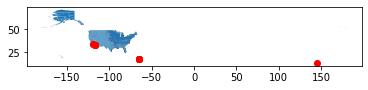

In [82]:
%matplotlib inline

ax = county_subd_gdf.plot()
locs_gdf[locs_gdf['PerCap'].isna() | locs_gdf['WhitePopPerc'].isna()].plot(ax=ax, color="red")

In [83]:
locs_gdf = locs_gdf[locs_gdf['PerCap'].notna() & locs_gdf['WhitePopPerc'].notna()]

Combine with user information from Twitter:

In [84]:
_, geo_users_df = load_users_dfs()
geo_users_df.drop(columns=["Locations","Has Geotags"], inplace=True)

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
locs_gdf = locs_gdf.merge(geo_users_df, how="left", on="U_ID")
locs_gdf

Users who are private are not defined in geo_users_df, but may be in locs_gdf (since locations came from tweets downloaded at a different time). Thus, we sift out those users:

In [ ]:
locs_gdf = locs_gdf.loc[locs_gdf["Private"].notna()]
locs_gdf

In [ ]:
locs_gdf = locs_gdf.reset_index()
locs_gdf.drop(columns=["index"], inplace=True)
locs_gdf

Finally, loop back to `county_subd_gdf` to add a per-cap adopters value.

In [ ]:
users_by_subdiv_df = locs_gdf.groupby('Geo_FIPS').agg({
    'U_ID': 'nunique',
}).reset_index()
users_by_subdiv_df.rename(columns={'U_ID': 'Adopters'}, inplace=True)
county_subd_gdf = pd.merge(
    county_subd_gdf,
    users_by_subdiv_df,
    how="left",
    on='Geo_FIPS',
)

county_subd_gdf['Adopters'] = county_subd_gdf['Adopters'].fillna(0)
county_subd_gdf['AdoptersPerCap'] = (county_subd_gdf['Adopters'] / county_subd_gdf['Total_Pop'])
county_subd_gdf

## General Stats

In [89]:
locs_gdf.describe()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets
count,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,3.437900e+04,34300.000000,34300.000000,3.437900e+04,34379.000000,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34050.000000,34194.000000,34379.000000,34379.000000,34379.000000,34300.000000,34050.000000,34379.000000,3.437900e+04,3.437900e+04
mean,1.579819e+03,2.598706e+09,25.902382,83.953693,71933.772506,8.556566e+05,8036.880040,192.025560,4.641589e+05,156743.689229,2.347540e+05,61.736517,18.027244,20.236247,23.307587,45324.986096,26451.629134,22605.882348,37659.224439,25.720033,0.000028,0.160133,0.630862,1196.417231,3.282625e+03,1.658021e+04
std,3.955855e+03,1.652377e+09,16.489786,108.017975,29841.414150,9.993318e+05,13604.529302,466.710048,5.485587e+05,221619.030296,3.245024e+05,18.226162,16.546325,13.338321,18.519561,18702.669909,9201.380373,8103.623555,13530.812948,36.069957,0.000037,0.161441,0.235241,4387.541000,5.706542e+04,3.645231e+04
min,0.000000e+00,1.001926e+08,1.000000,1.000000,70.000000,1.660000e+02,0.434984,0.032625,1.630000e+02,0.000000,0.000000e+00,1.380000,0.000000,0.000000,0.000000,4226.000000,602.000000,1611.000000,4725.000000,0.000000,0.000000,0.000000,0.020028,0.000000,0.000000e+00,1.000000e+00
25%,0.000000e+00,9.001336e+08,9.000000,31.000000,50000.000000,8.099300e+04,1933.357000,36.339705,5.553000e+04,6863.500000,9.244500e+03,47.780000,5.780000,9.550000,8.210000,33715.000000,20324.000000,18142.000000,29147.000000,1.000000,0.000011,0.023944,0.498853,290.000000,1.900000e+02,2.039000e+03
50%,2.328306e-10,2.605938e+09,26.000000,55.000000,90884.000000,3.957770e+05,3570.421000,87.658840,2.094240e+05,45888.000000,6.624500e+04,60.300000,11.880000,17.200000,18.750000,41883.000000,25557.000000,20597.000000,35563.000000,10.000000,0.000027,0.107292,0.611203,597.000000,4.600000e+02,6.379000e+03
75%,9.275834e+02,3.906102e+09,39.000000,97.000000,92522.000000,1.579075e+06,9067.710000,235.938329,7.563910e+05,240993.000000,4.233490e+05,76.380000,28.280000,28.450000,33.035000,49305.000000,30095.000000,26033.000000,41569.000000,34.000000,0.000037,0.272115,0.726091,1227.000000,1.169000e+03,1.745500e+04
max,2.993679e+04,7.214985e+09,72.000000,840.000000,98000.000000,3.433961e+06,71488.690000,24607.898341,2.556502e+06,833683.000000,1.050342e+06,100.000000,94.340000,98.430000,100.000000,156737.000000,192355.000000,238039.000000,164307.000000,204.000000,0.004762,2.579073,5.684942,362676.000000,6.848484e+06,2.355436e+06


## Histograms

To get a better grip on my data, construct histograms to examine feature distributions:

In [90]:
to_plot_df = locs_gdf.drop(labels=[
    'Geo_QNAME',
    'Geo_FIPS', 
    'Geo_STATE', 
    'Geo_COUNTY', 
    'Geo_COUSUB', 
    'U_ID',
    'mean-mode dev.',
    'geometry',
], axis=1)
to_plot_df.dtypes

Total_Pop                            float64
Pop_Dens                             float64
Land_Area                            float64
WhitePop                             float64
BlackPop                             float64
OtherRacePop                         float64
WhitePopPerc                         float64
BlackPopPerc                         float64
OtherRacePopPerc                     float64
PctLatinoPop                         float64
                                ...         
PoliceKillings                       float64
PKPerCap                             float64
PKPerSqMile                          float64
Blck_Wht_PerCap_Ratio                float64
Following                            float64
Followers                            float64
Tweets                               float64
Private                               object
Born                     datetime64[ns, UTC]
prior_adopter                         object
Length: 24, dtype: object

array([[<AxesSubplot:title={'center':'Total_Pop'}>,
        <AxesSubplot:title={'center':'Pop_Dens'}>,
        <AxesSubplot:title={'center':'Land_Area'}>,
        <AxesSubplot:title={'center':'WhitePop'}>,
        <AxesSubplot:title={'center':'BlackPop'}>,
        <AxesSubplot:title={'center':'OtherRacePop'}>,
        <AxesSubplot:title={'center':'WhitePopPerc'}>,
        <AxesSubplot:title={'center':'BlackPopPerc'}>,
        <AxesSubplot:title={'center':'OtherRacePopPerc'}>,
        <AxesSubplot:title={'center':'PctLatinoPop'}>,
        <AxesSubplot:title={'center':'WhitePerCap'}>],
       [<AxesSubplot:title={'center':'BlackPerCap'}>,
        <AxesSubplot:title={'center':'LatinoPerCap'}>,
        <AxesSubplot:title={'center':'PerCap'}>,
        <AxesSubplot:title={'center':'PoliceKillings'}>,
        <AxesSubplot:title={'center':'PKPerCap'}>,
        <AxesSubplot:title={'center':'PKPerSqMile'}>,
        <AxesSubplot:title={'center':'Blck_Wht_PerCap_Ratio'}>,
        <AxesSubplot:titl

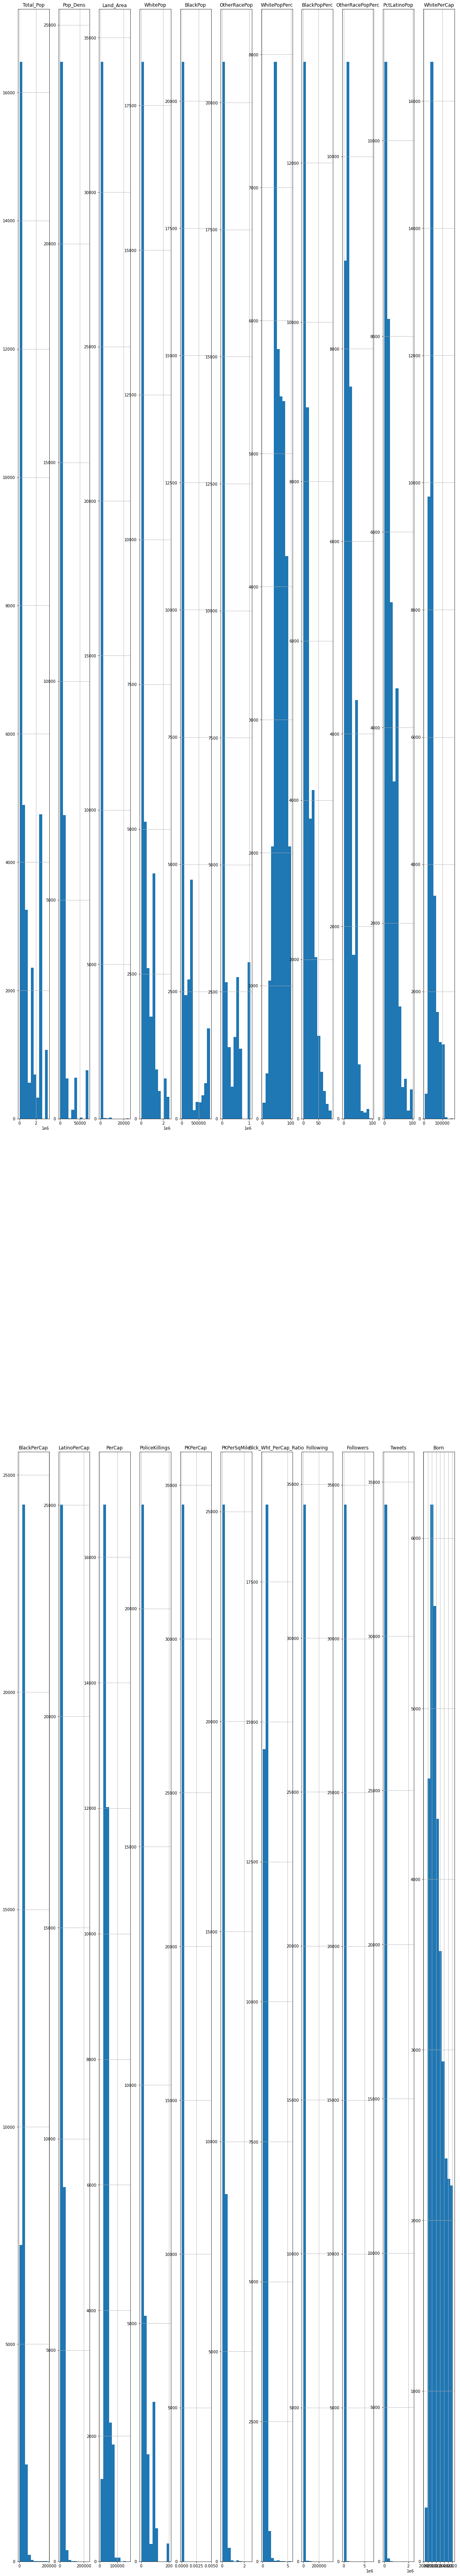

In [91]:
%matplotlib inline

fig, axis = plt.subplots(nrows=2,ncols=11,figsize=(20, 120))
to_plot_df.hist(ax=axis)

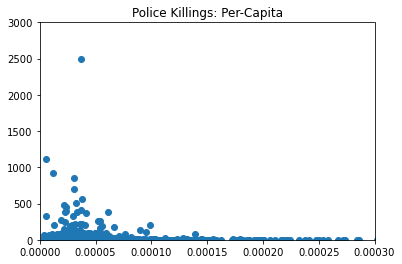

In [92]:
%matplotlib inline

pk_per_cap_df = locs_gdf.groupby('PKPerCap').agg({'U_ID': 'count'}).reset_index()

plt.xlim([0.00, 0.0003])
plt.ylim([0, 3000])

plt.title("Police Killings: Per-Capita")
plt.scatter(pk_per_cap_df['PKPerCap'], pk_per_cap_df['U_ID'])

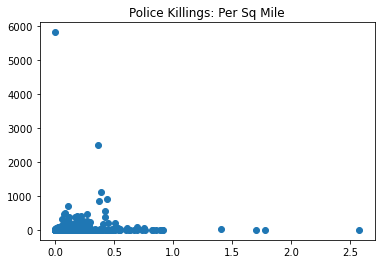

In [93]:
%matplotlib inline

pk_per_cap_df = locs_gdf.groupby('PKPerSqMile').agg({'U_ID': 'count'}).reset_index()

# plt.xlim([0.00, 0.0003])
# plt.ylim([0, 3000])

plt.title("Police Killings: Per Sq Mile")
plt.scatter(pk_per_cap_df['PKPerSqMile'], pk_per_cap_df['U_ID'])

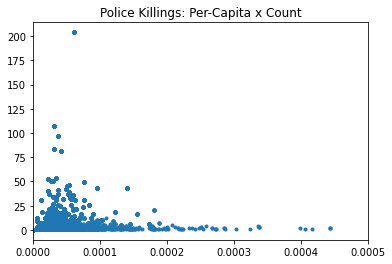

In [94]:
%matplotlib inline

plt.xlim([0.000, 0.0005])
plt.title("Police Killings: Per-Capita x Count")
plt.scatter(locs_gdf['PKPerCap'], locs_gdf['PoliceKillings'], marker='.')

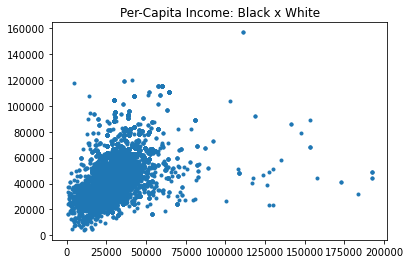

In [95]:
%matplotlib inline

plt.title("Per-Capita Income: Black x White")
plt.scatter(locs_gdf['BlackPerCap'], locs_gdf['WhitePerCap'], marker='.')

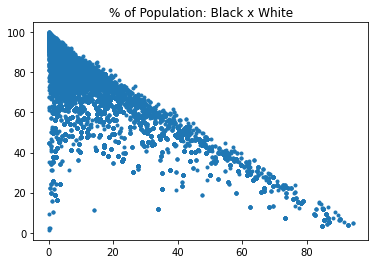

In [96]:
%matplotlib inline

plt.title("% of Population: Black x White")
plt.scatter(locs_gdf['BlackPopPerc'], locs_gdf['WhitePopPerc'], marker='.')

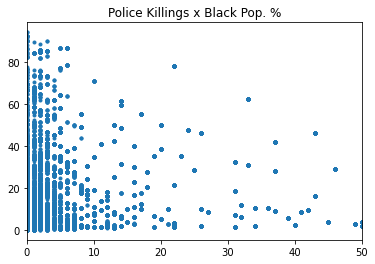

In [97]:
%matplotlib inline

plt.title("Police Killings x Black Pop. %")
plt.xlim([0, 50])
plt.scatter(locs_gdf['PoliceKillings'], locs_gdf['BlackPopPerc'], marker='.')

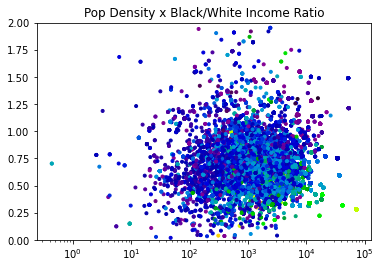

In [98]:
%matplotlib inline

plt.title("Pop Density x Black/White Income Ratio")
plt.ylim([0,2])
plt.xscale("log")
fig = plt.scatter(
    locs_gdf['Pop_Dens'], 
    locs_gdf['Blck_Wht_PerCap_Ratio'], 
    c=locs_gdf['WhitePerCap'], 
    cmap = 'nipy_spectral',
    marker='.'
)

## Linear Regression

First, a helper function to view the regression coefficients

In [99]:
def print_coeffs(coeffs, alpha):
    print()
    print(f"_______ COEFFS at ALPHA={alpha} ______")
    for tup in coeffs:
        print(f"{tup}")  

### 1. Per-Capita #BLM Adoption

Conduct regression with Lasso regularization, where the y-value is per-capita Twitter adopters, to identify which coefficients have the highest impact on behavior. We will use these coefficients to reduce the dimensions of our feature-space.

In [100]:
X = county_subd_gdf.drop(
    labels=[
        'Geo_QNAME',
        'Total_Pop',
        'WhitePop',
        'BlackPop',
        'OtherRacePop',
        'Geo_FIPS', 
        'Geo_STATE', 
        'Geo_NAME', 
        'Geo_COUNTY', 
        'Geo_COUSUB', 
        'Adopters', 
        'AdoptersPerCap',
        'PoliceKillings',
        'PKPerCap',
        'geometry'
    ], 
    axis=1)
y = county_subd_gdf['AdoptersPerCap']

X.dtypes
X = county_subd_gdf.drop(
    labels=[
        'Geo_QNAME',
        'Total_Pop',
        'WhitePop',
        'BlackPop',
        'OtherRacePop',
        'Geo_FIPS', 
        'Geo_STATE', 
        'Geo_NAME', 
        'Geo_COUNTY', 
        'Geo_COUSUB', 
        'Adopters', 
        'AdoptersPerCap',
        'PoliceKillings',
        'PKPerCap',
        'geometry'
    ], 
    axis=1)
y = county_subd_gdf['AdoptersPerCap']

In [101]:
alphas = [0, 0.000001, 0.000005, 0.00001]

for alpha in alphas:

    lasso = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='median'), 
        StandardScaler(), 
        Lasso(alpha=alpha, max_iter=2)
    )
    lasso.fit(X, y)

    coeffs = list(zip(lasso[-1].coef_, X.columns))
    print_coeffs(coeffs, alpha)


_______ COEFFS at ALPHA=0 ______
(1.698438696384654e-05, 'Pop_Dens')
(-5.118571808623745e-07, 'Land_Area')
(-8.06738572177152e-06, 'WhitePopPerc')
(1.5248336857492696e-06, 'BlackPopPerc')
(-1.906677580042007e-06, 'OtherRacePopPerc')
(3.3667166448969606e-06, 'PctLatinoPop')
(7.3099655793000285e-06, 'WhitePerCap')
(3.387218392698343e-06, 'BlackPerCap')
(2.039346006364348e-06, 'LatinoPerCap')
(-9.882291643963782e-07, 'PerCap')
(4.903368938758977e-06, 'PKPerSqMile')
(-2.7036100937901504e-06, 'Blck_Wht_PerCap_Ratio')

_______ COEFFS at ALPHA=1e-06 ______
(1.6325581040083313e-05, 'Pop_Dens')
(-0.0, 'Land_Area')
(-6.661022823196301e-06, 'WhitePopPerc')
(1.804957696180346e-06, 'BlackPopPerc')
(-0.0, 'OtherRacePopPerc')
(1.8063651708052482e-06, 'PctLatinoPop')
(5.593669179804927e-06, 'WhitePerCap')
(1.383150335409054e-06, 'BlackPerCap')
(1.5047735568175274e-06, 'LatinoPerCap')
(0.0, 'PerCap')
(4.228615353272555e-06, 'PKPerSqMile')
(-7.57094527565095e-08, 'Blck_Wht_PerCap_Ratio')

_______ COEFF

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e-04, tolerance: 5.004e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mo

#### Graph Per-Capita Twitter Usage:

<AxesSubplot:title={'center':'Per-Capita Geotagged Adopters'}>

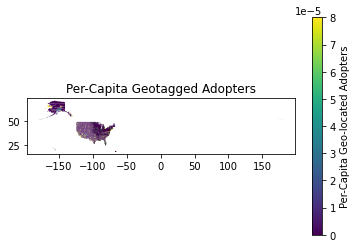

In [102]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Per-Capita Geotagged Adopters")
county_subd_gdf.plot(
    ax=ax,
    column='AdoptersPerCap', 
    legend=True, 
    vmin=0.0, 
    vmax=0.00008,
    legend_kwds={'label': "Per-Capita Geo-located Adopters"}
)

### 2. Mean Number of Friends

Conduct a similiar regression, but to see what factors impact number of Twitter friends (people a user has followed). First, load the dataframe: 

In [ ]:
subdivs_by_followers = locs_gdf.groupby("Geo_FIPS").mean()
subdivs_by_followers.reset_index(inplace=True)
subdivs_by_followers

Now run the regression:

In [104]:
alphas = [1.0, 2.0, 3.0]

X = subdivs_by_followers.drop([
    "Geo_FIPS",
    'mean-mode dev.',
    'Land_Area',
    "Geo_STATE",
    "Geo_COUNTY",
    "Geo_COUSUB",
    "Following",
    "Followers",
    "PoliceKillings",
    "PKPerCap",
    "Tweets"
], axis=1)
y = subdivs_by_followers["Following"]

for alpha in alphas:

    lasso = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='median'), 
        StandardScaler(), 
        Lasso(alpha=alpha, max_iter=2000)
    )

    lasso.fit(X, y)
    y = lasso.predict(X)
    coeffs = list(zip(lasso[-1].coef_, X.columns))
    print_coeffs(coeffs, alpha)


_______ COEFFS at ALPHA=1.0 ______
(0.0, 'Total_Pop')
(-4.080630956706902, 'Pop_Dens')
(1.0241831919654256, 'WhitePop')
(10.64303913189807, 'BlackPop')
(-3.2411602713322147, 'OtherRacePop')
(-0.0, 'WhitePopPerc')
(56.34024486374839, 'BlackPopPerc')
(-16.440927325973824, 'OtherRacePopPerc')
(-34.25091138118526, 'PctLatinoPop')
(-206.25367810776612, 'WhitePerCap')
(-55.91881729166822, 'BlackPerCap')
(-66.20470122944758, 'LatinoPerCap')
(394.919941575889, 'PerCap')
(-2.1896132157232175, 'PKPerSqMile')
(62.81201134464202, 'Blck_Wht_PerCap_Ratio')

_______ COEFFS at ALPHA=2.0 ______
(0.0, 'Total_Pop')
(-2.005089306486521, 'Pop_Dens')
(0.0, 'WhitePop')
(1.943006937448537, 'BlackPop')
(-0.0, 'OtherRacePop')
(-0.0, 'WhitePopPerc')
(34.56279223643958, 'BlackPopPerc')
(-33.42083741822134, 'OtherRacePopPerc')
(-27.44213650097295, 'PctLatinoPop')
(-37.43584083594625, 'WhitePerCap')
(-38.99025607699926, 'BlackPerCap')
(-58.75029007085805, 'LatinoPerCap')
(210.30840633352747, 'PerCap')
(-1.47446785

#### Graph Mean Following Count

<AxesSubplot:title={'center':'Avg. Friends by Subdivision'}>

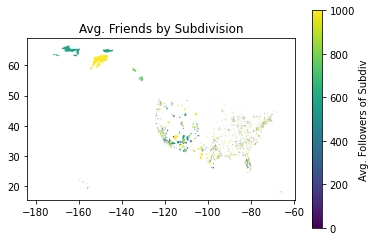

In [105]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Avg. Friends by Subdivision")
county_subd_gdf.merge(subdivs_by_followers, how="left", on="Geo_FIPS").plot(
    ax=ax,
    column='Following', 
    legend=True, 
    vmax=1000,
    legend_kwds={'label': "Avg. Followers of Subdiv"}
)

## K-Means Clustering

Inertia is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. 

A good model is one with low inertia AND a low number of clusters ( K ).

First, we determine the ideal number of clusters with the "elbow" method -- plotting inertia x number of clusters and seeing where the benefit of added k tapers off.

In [107]:
def print_cluster_coeffs(cluster_centers, X_cols, k, inertia):
    print()
    print(f"_______ COEFFS at K={k} ______")
    print(f"Inertia: {inertia}")
    print()
    
    for idx in range(len(cluster_centers)):
        
        cluster_coeffs = cluster_centers[idx]   
        coeffs = list(zip(cluster_coeffs, X.columns))
        print(f"_______ Cluster ______")
        for tup in coeffs:
            print(f"{tup}") 
            
        print()
        
    print("____________")
    

In [ ]:
X = locs_gdf[[
    'WhitePopPerc',
    'BlackPopPerc',
    'OtherRacePopPerc',
    'PctLatinoPop',
    'WhitePerCap',
    'BlackPerCap',
    'LatinoPerCap',
    'PerCap',
    'PKPerSqMile',
    'Blck_Wht_PerCap_Ratio',
    'Pop_Dens'
]]
X

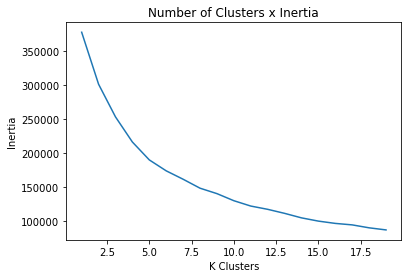

In [109]:
%matplotlib inline

k_vals = range(1, 20)
inertias = []

for k in k_vals:
    
    km = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='median'), 
        StandardScaler(), 
        KMeans(n_clusters=k, init='k-means++' )
    )
    km.fit(X)  
    inertias.append(km[-1].inertia_)
    
    
plt.ylabel("Inertia")
plt.xlabel("K Clusters")
plt.title("Number of Clusters x Inertia")
plt.plot(k_vals, inertias)

In [110]:
locs_gdf.describe()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets
count,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,3.437900e+04,34300.000000,34300.000000,3.437900e+04,34379.000000,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34050.000000,34194.000000,34379.000000,34379.000000,34379.000000,34300.000000,34050.000000,34379.000000,3.437900e+04,3.437900e+04
mean,1.579819e+03,2.598706e+09,25.902382,83.953693,71933.772506,8.556566e+05,8036.880040,192.025560,4.641589e+05,156743.689229,2.347540e+05,61.736517,18.027244,20.236247,23.307587,45324.986096,26451.629134,22605.882348,37659.224439,25.720033,0.000028,0.160133,0.630862,1196.417231,3.282625e+03,1.658021e+04
std,3.955855e+03,1.652377e+09,16.489786,108.017975,29841.414150,9.993318e+05,13604.529302,466.710048,5.485587e+05,221619.030296,3.245024e+05,18.226162,16.546325,13.338321,18.519561,18702.669909,9201.380373,8103.623555,13530.812948,36.069957,0.000037,0.161441,0.235241,4387.541000,5.706542e+04,3.645231e+04
min,0.000000e+00,1.001926e+08,1.000000,1.000000,70.000000,1.660000e+02,0.434984,0.032625,1.630000e+02,0.000000,0.000000e+00,1.380000,0.000000,0.000000,0.000000,4226.000000,602.000000,1611.000000,4725.000000,0.000000,0.000000,0.000000,0.020028,0.000000,0.000000e+00,1.000000e+00
25%,0.000000e+00,9.001336e+08,9.000000,31.000000,50000.000000,8.099300e+04,1933.357000,36.339705,5.553000e+04,6863.500000,9.244500e+03,47.780000,5.780000,9.550000,8.210000,33715.000000,20324.000000,18142.000000,29147.000000,1.000000,0.000011,0.023944,0.498853,290.000000,1.900000e+02,2.039000e+03
50%,2.328306e-10,2.605938e+09,26.000000,55.000000,90884.000000,3.957770e+05,3570.421000,87.658840,2.094240e+05,45888.000000,6.624500e+04,60.300000,11.880000,17.200000,18.750000,41883.000000,25557.000000,20597.000000,35563.000000,10.000000,0.000027,0.107292,0.611203,597.000000,4.600000e+02,6.379000e+03
75%,9.275834e+02,3.906102e+09,39.000000,97.000000,92522.000000,1.579075e+06,9067.710000,235.938329,7.563910e+05,240993.000000,4.233490e+05,76.380000,28.280000,28.450000,33.035000,49305.000000,30095.000000,26033.000000,41569.000000,34.000000,0.000037,0.272115,0.726091,1227.000000,1.169000e+03,1.745500e+04
max,2.993679e+04,7.214985e+09,72.000000,840.000000,98000.000000,3.433961e+06,71488.690000,24607.898341,2.556502e+06,833683.000000,1.050342e+06,100.000000,94.340000,98.430000,100.000000,156737.000000,192355.000000,238039.000000,164307.000000,204.000000,0.004762,2.579073,5.684942,362676.000000,6.848484e+06,2.355436e+06


We want to simplify our feature space, so from now on using `load_X_for_clustering()` to grab a few salient chars. from `locs_gdf`.

In [111]:
%matplotlib qt

# CONVERT DATA to CORRECT format!

def load_X_for_clustering():
    
    X = locs_gdf[
        [
        'Pop_Dens',
        'PKPerSqMile',
        'WhitePopPerc',
        'BlackPopPerc',
        'WhitePerCap',
        'BlackPerCap',
        ]
    ]
    cols = X.columns
    clean_data = make_pipeline(
            SimpleImputer(missing_values=np.nan, strategy='median'), 
            StandardScaler(), 
        )
    clean_data.fit(X)  
    X = pd.DataFrame(
        data=clean_data.transform(X), 
        index=None, 
        columns=cols
    )
    X = X.clip(lower=-2.0, upper=2.0)
    return X

X = load_X_for_clustering()
X.describe(percentiles=[0.1*x for x in range(1,10)])

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap
count,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000
mean,-0.089974,-0.018430,0.010804,-0.040242,-0.053404,-0.035377
std,0.632849,0.931282,0.974335,0.885940,0.853503,0.818921
min,-0.590578,-0.992178,-2.000000,-1.089517,-2.000000,-2.000000
10%,-0.541993,-0.992178,-1.156405,-0.961995,-0.994032,-1.010324
20%,-0.477622,-0.929009,-0.840920,-0.809088,-0.740546,-0.758291
30%,-0.415446,-0.761938,-0.669186,-0.690631,-0.548731,-0.533448
40%,-0.364628,-0.520250,-0.287312,-0.485145,-0.412727,-0.321928
50%,-0.327894,-0.326895,-0.078817,-0.371523,-0.184040,-0.096758
60%,-0.259673,-0.003575,0.288791,-0.097863,0.000482,0.112141


In [112]:
def get_agg_df(X):

    X_counts = X
    X_counts["num_users"] = 1
    X_counts = X_counts.groupby([X_counts[col] for col in X_counts.columns]).agg({
        'num_users': 'count'
    })
    X_counts.rename({'num_users': 'Adopters'}, axis=1, inplace=True)
    X_counts.reset_index(inplace=True)
    X_counts.drop("num_users", axis=1, inplace=True)
    return X_counts

get_agg_df(load_X_for_clustering()).describe()

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap,Adopters
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000
mean,-0.451091,-0.802536,0.890210,-0.460599,-0.442265,-0.153763,9.326913
std,0.202724,0.459097,0.960602,0.796513,0.730121,1.078307,58.836478
min,-0.590578,-0.992178,-2.000000,-1.089517,-2.000000,-2.000000,1.000000
25%,-0.565694,-0.992178,0.455038,-0.988436,-0.941710,-0.956079,1.000000
50%,-0.514485,-0.992178,1.175716,-0.797001,-0.589683,-0.212073,2.000000
75%,-0.409946,-0.828229,1.607519,-0.287515,-0.093477,0.519647,5.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2499.000000


In [113]:
subdiv_counts_df = get_agg_df(load_X_for_clustering())

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=subdiv_counts_df['Pop_Dens'].clip(upper=0.6), 
    ys=subdiv_counts_df['BlackPopPerc'].clip(upper=1.5), 
    zs=subdiv_counts_df['WhitePerCap'], 
    s=(subdiv_counts_df['Adopters']**1/2)
)
ax.set_xlabel('Population Density')
ax.set_zlabel('White PerCap Income')
ax.set_ylabel('% Black')

plt.show()

Now I examine inertia at varying values of K to determine how many groups to form.

Using Only Index(['Pop_Dens', 'PKPerSqMile', 'WhitePopPerc', 'BlackPopPerc', 'WhitePerCap', 'BlackPerCap'], dtype='object')


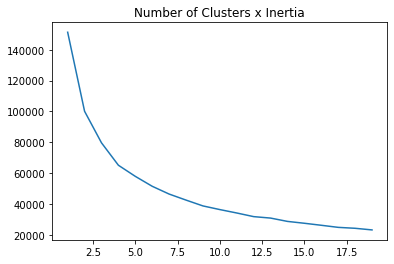

In [114]:
%matplotlib inline

X = load_X_for_clustering()

k_vals = range(1, 20)
inertias = []

for k in k_vals:
    
    km = KMeans(n_clusters=k, init='k-means++')
    km.fit(X)  
    inertias.append(km.inertia_)  
    
print(f"Using Only {X.columns}")
plt.title("Number of Clusters x Inertia")
plt.plot(k_vals, inertias)

Given this information, I decide to go with K=5 (5 clusters).

In [115]:
X = load_X_for_clustering()

km = KMeans(n_clusters=5, init='k-means++')
km.fit(X)  

cluster_centers = km.cluster_centers_
X["cluster_label"] = km.predict(X)   # this should work because X has the same number of rows, same user_ids represented as locs_gdf

X.groupby("cluster_label").count()

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap
cluster_label,,,,,,
0,7457,7457,7457,7457,7457,7457
1,7937,7937,7937,7937,7937,7937
2,7050,7050,7050,7050,7050,7050
3,7814,7814,7814,7814,7814,7814
4,4121,4121,4121,4121,4121,4121


In order to see what these clusters represent, I display in 2 projections of feature-space, each using 3 of 6 salient dimensions:

In [116]:
%matplotlib qt
# Then plot!

X_c = get_agg_df(X)

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=X_c['BlackPopPerc'], 
    ys=X_c['BlackPerCap'], 
    zs=X_c['PKPerSqMile'], 
    s=(X_c['Adopters']**1/2),
    c=X_c['cluster_label'],
    cmap='nipy_spectral'
)
ax.set_xlabel('Percent Black')
ax.set_ylabel('Black Income (Per Cap.)')
ax.set_zlabel('Police Killings (Per Sq. Mile)')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
cbar.set_label('Cluster Label')

colors = ["black", "powderblue", "lightgreen", "orange", "grey"]

for idx in range(len(km.cluster_centers_)):
    center = km.cluster_centers_[idx]
    x, y, z = center[0:3]
    ax.plot3D([0, x], [0, y], [0, z], colors[idx])

plt.show()

In [117]:
%matplotlib qt
# Then plot!

X_c = get_agg_df(X)

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=X_c['WhitePopPerc'], #.clip(upper=0.6), 
    ys=X_c['WhitePerCap'], #.clip(upper=1.5), 
    zs=X_c['Pop_Dens'],
    s=(X_c['Adopters']**1/2),
    c=X_c['cluster_label'],
    cmap='nipy_spectral'
)
ax.set_xlabel('Percent White')
ax.set_ylabel('White Income (Per Cap.)')
ax.set_zlabel('Pop. (Per Sq. Mile)')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
cbar.set_label('Cluster Label')

colors = ["black", "blue", "powderblue", "lightgreen", "orange", "grey"]

for idx in range(len(km.cluster_centers_)):
    center = km.cluster_centers_[idx]
    x, y, z = center[3:6]
    ax.plot3D([0, x], [0, y], [0, z], colors[idx])

plt.show()

Now I convert the centroid labels from standardized values to real values, to see if they're meaningful.

In [118]:
ftr_names = km.feature_names_in_
describe_locs_gdf = locs_gdf.describe()

for idx in range(len(km.cluster_centers_)):
    
    center = km.cluster_centers_[idx]
    
    for ftr in range(len(center)):
        val = center[ftr]*describe_locs_gdf.loc["std",ftr_names[ftr]]
        val += describe_locs_gdf.loc["mean",ftr_names[ftr]]
        
        print(f"{ftr_names[ftr]}:\t{round(val, 2)}\t{round(center[ftr], 2)}")
        
    print()

Pop_Dens:	2160.72	-0.43
PKPerSqMile:	0.05	-0.67
WhitePopPerc:	82.95	1.16
BlackPopPerc:	6.14	-0.72
WhitePerCap:	32908.95	-0.66
BlackPerCap:	20783.36	-0.62

Pop_Dens:	18372.37	0.76
PKPerSqMile:	0.38	1.33
WhitePopPerc:	47.07	-0.8
BlackPopPerc:	20.68	0.16
WhitePerCap:	57022.63	0.63
BlackPerCap:	28852.86	0.26

Pop_Dens:	3237.58	-0.35
PKPerSqMile:	0.05	-0.7
WhitePopPerc:	70.6	0.49
BlackPopPerc:	6.41	-0.7
WhitePerCap:	50861.37	0.3
BlackPerCap:	35861.8	1.02

Pop_Dens:	3984.92	-0.3
PKPerSqMile:	0.14	-0.14
WhitePopPerc:	61.32	-0.02
BlackPopPerc:	19.43	0.08
WhitePerCap:	37670.41	-0.41
BlackPerCap:	21926.11	-0.49

Pop_Dens:	4443.09	-0.26
PKPerSqMile:	0.15	-0.05
WhitePopPerc:	38.9	-1.25
BlackPopPerc:	46.07	1.69
WhitePerCap:	41921.72	-0.18
BlackPerCap:	21807.01	-0.5



In [119]:
locs_gdf["cluster_label"] = X["cluster_label"]
for col in ['Pop_Dens','PKPerSqMile','WhitePopPerc','BlackPopPerc','WhitePerCap','BlackPerCap']:
    locs_gdf[f"{col}_std"] = X[col]
locs_gdf.groupby("cluster_label").mean()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1797.649992,2.990379e+09,29.822046,81.008583,73658.550221,3.229688e+05,2188.402347,209.989912,252286.681776,19455.863618,51226.298109,82.952788,6.137866,10.909772,20.860889,32936.376023,20558.053911,20216.061715,31038.275312,15.992088,0.000027,0.052553,0.653378,1129.983237,1827.080595,16106.177551,-0.431864,-0.665871,1.163811,-0.718561,-0.663120,-0.614242
1,1090.498467,1.871319e+09,18.670908,41.711982,57008.392592,1.922605e+06,23579.627162,137.467407,909738.373441,381732.324430,631134.316870,46.989055,20.683126,32.328155,32.379682,60955.426106,28832.856243,24045.503843,45089.554996,50.265970,0.000027,0.380390,0.528553,1276.630087,7047.594431,15969.399899,0.759709,1.331634,-0.804548,0.160514,0.625453,0.260964
2,1839.010605,2.394234e+09,23.850922,90.635177,77814.391915,4.879922e+05,3272.920829,229.938996,308961.951631,26257.112340,152773.100851,70.473974,6.417186,23.107316,19.815389,51309.319716,37472.679994,28141.444334,46932.137305,10.744823,0.000016,0.046564,0.772556,1227.007943,2450.117163,15611.921277,-0.352692,-0.701527,0.485266,-0.701680,0.296958,1.023792
3,1658.875417,2.981259e+09,29.717558,94.254287,78222.668416,8.263296e+05,3979.656197,237.623636,504005.038521,148079.916944,174244.643588,61.300340,19.431400,19.268723,26.167272,37667.185052,21929.774090,19722.875768,32035.771180,29.510878,0.000036,0.139732,0.613238,1140.697082,2268.416560,16677.471206,-0.297866,-0.140229,-0.022920,0.084863,-0.409392,-0.492023
4,1534.761852,2.915329e+09,29.012861,139.678233,75573.974763,4.492213e+05,4437.824194,113.802548,179312.506916,211499.719728,58409.043921,37.628314,51.625445,10.746615,10.814069,41920.853191,21872.840087,20077.944526,30128.409609,14.478525,0.000041,0.162068,0.580518,1215.461538,2012.455957,20086.444310,-0.264162,-0.047530,-1.252958,1.694870,-0.181967,-0.504774


## K-Means (Take 2, by Subdiv.)

I realize that my initial approach to K means had the side effect of ignoring those county subdivisions which did not have much adoption at all, which are still analytically relevant. This take to examines K means across all subdivisions, using a weighted medium this time.

In [120]:
# FROM HERE: https://stackoverflow.com/questions/26102867/python-weighted-median-algorithm-with-pandas

def wtd_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

In [121]:
cols =  ['Pop_Dens', 'PKPerSqMile', 'WhitePopPerc', 'BlackPopPerc','WhitePerCap', 'BlackPerCap']
for col in cols:
    county_subd_gdf[f"{col}_std"] = county_subd_gdf[col]
    county_subd_gdf.fillna(
        value={
            f"{col}_std": wtd_median(county_subd_gdf, col, 'Total_Pop')
        }, 
        inplace=True
    )
    
std_cols = [f"{col}_std" for col in cols]
print(std_cols)

s = StandardScaler()
county_subd_gdf.loc[:, std_cols] = s.fit_transform(
    X = county_subd_gdf.loc[:, std_cols], 
    sample_weight = county_subd_gdf.loc[:, "Total_Pop"]
)

csub_std_df = pd.DataFrame(county_subd_gdf.loc[:, std_cols])
csub_std_df.clip(lower=-2.0, upper=2.0, inplace=True)

county_subd_gdf.loc[:, std_cols] = csub_std_df
county_subd_gdf.describe()

['Pop_Dens_std', 'PKPerSqMile_std', 'WhitePopPerc_std', 'BlackPopPerc_std', 'WhitePerCap_std', 'BlackPerCap_std']


,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Adopters,AdoptersPerCap,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
count,3.609900e+04,36099.000000,36099.000000,36099.000000,3.609900e+04,35935.000000,35935.000000,3.609900e+04,36099.000000,3.609900e+04,36099.000000,36099.000000,36099.000000,36099.000000,35499.000000,12917.000000,17121.000000,35572.000000,36099.000000,36099.000000,35935.000000,12897.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000
mean,3.204561e+09,31.962077,82.928087,60152.618106,9.086574e+03,456.789764,96.973384,6.580949e+03,1152.977035,1.352648e+03,88.917793,5.160535,5.921656,7.274752,32055.453309,22914.766819,20948.759243,30843.422242,0.223801,0.000026,0.006402,0.738738,0.952353,0.000017,-0.405122,-0.538002,0.848320,-0.521132,-0.422155,-0.155978
std,1.474881e+09,14.749915,67.613777,30977.136060,5.807135e+04,1404.784462,818.072410,3.510661e+04,12133.266138,1.631819e+04,16.906969,12.941793,10.566261,17.709235,13834.467362,17076.419762,18096.346440,13627.507547,2.061354,0.000599,0.055775,0.505072,19.009482,0.000118,0.174888,0.234600,0.784024,0.643753,0.759227,0.627455
min,1.001902e+08,1.000000,1.000000,70.000000,1.000000e+00,0.001521,0.004915,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,875.000000,23.000000,52.000000,832.000000,0.000000,0.000000,0.000000,0.001229,0.000000,0.000000,-0.470305,-0.579824,-2.000000,-0.812009,-2.000000,-2.000000
25%,2.014351e+09,20.000000,31.000000,32906.000000,4.090000e+02,10.798565,21.654164,3.650000e+02,0.000000,4.000000e+00,87.335000,0.000000,0.590000,0.000000,24775.000000,13438.000000,12062.000000,23617.000000,0.000000,0.000000,0.000000,0.477688,0.000000,0.000000,-0.468743,-0.579824,0.751820,-0.812009,-0.898791,-0.035321
50%,3.101190e+09,31.000000,73.000000,65503.000000,1.497000e+03,43.909340,35.600690,1.292000e+03,5.000000,4.100000e+01,95.550000,0.280000,2.880000,1.760000,29755.000000,19441.000000,17495.000000,28703.500000,0.000000,0.000000,0.000000,0.661769,0.000000,0.000000,-0.463947,-0.579824,1.166054,-0.794090,-0.542383,-0.035321
75%,4.204576e+09,42.000000,121.000000,91170.000000,4.757500e+03,238.155600,54.086595,4.037500e+03,138.000000,2.430000e+02,98.910000,2.920000,6.570000,5.430000,36423.000000,28164.000000,25079.000000,35284.000000,0.000000,0.000000,0.000000,0.878522,0.000000,0.000000,-0.434850,-0.579824,1.335480,-0.625146,-0.095375,-0.035321
max,7.215388e+09,72.000000,840.000000,98000.000000,3.433961e+06,71488.690000,88695.410024,2.556502e+06,833683.000000,1.050342e+06,100.000000,100.000000,100.000000,100.000000,449605.000000,417268.000000,904414.000000,449605.000000,204.000000,0.076923,2.594289,12.321448,2499.000000,0.010080,2.000000,2.000000,1.390442,2.000000,2.000000,2.000000


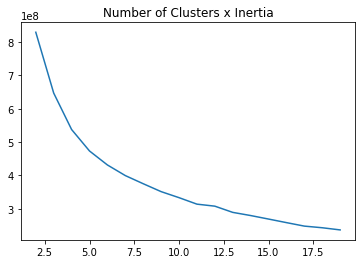

In [122]:
%matplotlib inline

inertias = []
k_vals = range(2, 20)
for n in k_vals:

    km = KMeans(n_clusters=n, init='k-means++')
    km.fit(X=county_subd_gdf.loc[:, std_cols], sample_weight=county_subd_gdf.loc[:, "Total_Pop"])
    inertias.append(km.inertia_)  
    
plt.title("Number of Clusters x Inertia")
plt.plot(k_vals, inertias)

Now, the tricky part, adding this to locs_gdf:

In [123]:
for col in cols:
    locs_gdf[f"{col}_std"] = locs_gdf[col]
    locs_gdf.fillna(
        value={
            f"{col}_std": wtd_median(county_subd_gdf, col, 'Total_Pop')
        }, 
        inplace=True
    )
    
locs_gdf[std_cols] = s.transform(locs_gdf.loc[:, std_cols])
locs_gdf.describe()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,cluster_label,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
count,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,3.437900e+04,34300.000000,34300.000000,3.437900e+04,34379.000000,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34050.000000,34194.000000,34379.000000,34379.000000,34379.000000,34300.000000,34050.000000,34379.000000,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000
mean,1.579819e+03,2.598706e+09,25.902382,83.953693,71933.772506,8.556566e+05,8036.880040,192.025560,4.641589e+05,156743.689229,2.347540e+05,61.736517,18.027244,20.236247,23.307587,45324.986096,26451.629134,22605.882348,37659.224439,25.720033,0.000028,0.160133,0.630862,1196.417231,3.282625e+03,1.658021e+04,1.802350,0.680125,0.770593,-0.538963,0.341629,0.542345,0.036051
std,3.955855e+03,1.652377e+09,16.489786,108.017975,29841.414150,9.993318e+05,13604.529302,466.710048,5.485587e+05,221619.030296,3.245024e+05,18.226162,16.546325,13.338321,18.519561,18702.669909,9201.380373,8103.623555,13530.812948,36.069957,0.000037,0.161441,0.235241,4387.541000,5.706542e+04,3.645231e+04,1.329001,1.949278,1.363909,0.919040,1.058868,1.318129,0.796388
min,0.000000e+00,1.001926e+08,1.000000,1.000000,70.000000,1.660000e+02,0.434984,0.032625,1.630000e+02,0.000000,0.000000e+00,1.380000,0.000000,0.000000,0.000000,4226.000000,602.000000,1611.000000,4725.000000,0.000000,0.000000,0.000000,0.020028,0.000000,0.000000e+00,1.000000e+00,0.000000,-0.470243,-0.579824,-3.582392,-0.812009,-2.354235,-2.211264
25%,0.000000e+00,9.001336e+08,9.000000,31.000000,50000.000000,8.099300e+04,1933.357000,36.339705,5.553000e+04,6863.500000,9.244500e+03,47.780000,5.780000,9.550000,8.210000,33715.000000,20324.000000,18142.000000,29147.000000,1.000000,0.000011,0.023944,0.498853,290.000000,1.900000e+02,2.039000e+03,1.000000,-0.193044,-0.380999,-1.242709,-0.442123,-0.275905,-0.490059
50%,2.328306e-10,2.605938e+09,26.000000,55.000000,90884.000000,3.957770e+05,3570.421000,87.658840,2.094240e+05,45888.000000,6.624500e+04,60.300000,11.880000,17.200000,18.750000,41883.000000,25557.000000,20597.000000,35563.000000,10.000000,0.000027,0.107292,0.611203,597.000000,4.600000e+02,6.379000e+03,2.000000,0.041726,0.326842,-0.611399,-0.051758,0.299761,-0.035321
75%,9.275834e+02,3.906102e+09,39.000000,97.000000,92522.000000,1.579075e+06,9067.710000,235.938329,7.563910e+05,240993.000000,4.233490e+05,76.380000,28.280000,28.450000,33.035000,49305.000000,30095.000000,26033.000000,41569.000000,34.000000,0.000037,0.272115,0.726091,1227.000000,1.169000e+03,1.745500e+04,3.000000,0.830088,1.719667,0.199423,0.997745,0.822849,0.353585
max,2.993679e+04,7.214985e+09,72.000000,840.000000,98000.000000,3.433961e+06,71488.690000,24607.898341,2.556502e+06,833683.000000,1.050342e+06,100.000000,94.340000,98.430000,100.000000,156737.000000,192355.000000,238039.000000,164307.000000,204.000000,0.004762,2.579073,5.684942,362676.000000,6.848484e+06,2.355436e+06,4.000000,9.781831,21.214474,1.390442,5.225198,8.394457,14.464471


In [124]:
km = KMeans(n_clusters=6, init='k-means++')
km.fit(X=county_subd_gdf.loc[:, std_cols], sample_weight=county_subd_gdf.loc[:, "Total_Pop"])

KMeans(n_clusters=6)

In [125]:
locs_gdf["cluster_label"] = km.predict(X=locs_gdf.loc[:, std_cols])

print([f"{len(c)} in {c_l}" for (c_l, c) in locs_gdf.groupby(["cluster_label"])])
locs_gdf.groupby(["cluster_label"]).mean()

['3146 in 0', '4930 in 1', '7897 in 2', '3472 in 3', '10467 in 4', '4467 in 5']


,mean-mode dev.,Geo_FIPS,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1996.854593,2.949673e+09,29.404959,91.081373,69038.194851,1.023946e+05,1572.299372,154.252852,86667.785760,3832.077877,11894.695486,87.522495,3.808334,8.669488,15.312540,36541.303878,27967.694715,23552.126561,35290.297521,2.208837,0.000019,0.019168,0.800584,1210.844882,1795.046726,15981.930070,-0.244825,-0.417884,0.761274,-0.568298,-0.076712,0.151085
1,1622.769566,2.800738e+09,27.893915,112.728600,73543.613590,3.091773e+05,2959.099236,119.632077,144198.564503,129875.945233,35102.796755,44.715712,44.842507,10.442266,11.941625,39026.962880,21600.859606,19226.783833,29586.979310,11.342799,0.000038,0.103088,0.607865,1231.013590,2092.861866,19104.503245,-0.046672,0.288660,-1.397224,2.057649,0.098473,-0.385034
2,1723.417907,2.668516e+09,26.581740,102.564392,85807.426364,1.107236e+06,3383.025336,341.007142,721405.772572,134406.638090,251424.051032,65.566738,12.341655,22.091130,29.834849,37680.826263,24913.234742,20499.742177,33400.608459,40.076485,0.000033,0.107417,0.675923,1083.642016,2168.597062,17064.078004,0.014786,0.327701,-0.345828,-0.022215,0.003599,-0.096920
3,1820.452609,3.235087e+09,32.262385,87.736463,74548.868088,1.503770e+05,1777.689602,187.692021,121412.580069,9695.862039,19268.515265,81.791210,7.723629,10.484781,25.308122,27922.853111,16463.443513,17467.655433,26217.923387,6.310484,0.000026,0.040557,0.617357,1128.728399,1843.517281,16330.353399,-0.215464,-0.237729,0.472278,-0.317742,-0.684124,-0.829355
4,1126.568944,2.195091e+09,21.892424,57.884590,59814.252126,1.636705e+06,19955.945161,126.627040,780603.593580,342018.894908,514082.740422,48.113876,22.459145,29.427582,29.419089,56985.151715,27052.528709,23480.883241,42560.522404,44.208178,0.000031,0.360810,0.526397,1258.890035,5891.861756,15951.859559,2.391561,2.469179,-1.225874,0.625245,1.364132,0.088998
5,1859.860058,2.456253e+09,24.489366,72.419969,74035.436758,2.625685e+05,3265.701642,191.456292,153279.554959,13736.766958,95552.203716,71.922532,6.121710,21.954786,14.067799,58179.676293,39966.692065,31327.245957,53173.308708,4.530781,0.000012,0.036377,0.723350,1253.670248,2617.442355,15026.742109,-0.004211,-0.273913,-0.025342,-0.420255,1.448320,1.203417


In [126]:
county_subd_gdf["cluster_label"] = km.predict(X=county_subd_gdf.loc[:, std_cols])

In [127]:
%matplotlib qt

fig, ax = plt.subplots(1, 1)

county_subd_gdf.boundary.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=0.1
)
county_subd_gdf.loc[county_subd_gdf["Adopters"] > 0, :].plot(
    ax=ax,
    legend=True,
    column="cluster_label",
    cmap='nipy_spectral',
    edgecolor="black",
    linewidth=0.1
)

<AxesSubplot:>

In [128]:
locs_count = locs_gdf.groupby(["cluster_label"]).agg({"U_ID": "count"})

In [129]:
%matplotlib qt
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=county_subd_gdf['WhitePopPerc_std'],
    ys=county_subd_gdf['WhitePerCap_std'],
    zs=county_subd_gdf['Pop_Dens_std'],
    s=(county_subd_gdf['Adopters']**1/2),
    c=county_subd_gdf["cluster_label"],
    cmap='nipy_spectral'
)
ax.set_xlabel('Percent White')
ax.set_ylabel('White Income (per cap.)')
ax.set_zlabel('Pop. (per sq. mi.)')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
cbar.set_label('Cluster Label')

plt.show()

In [130]:
%matplotlib qt
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=county_subd_gdf['BlackPopPerc_std'],
    ys=county_subd_gdf['BlackPerCap_std'],
    zs=county_subd_gdf['PKPerSqMile_std'],
    s=(county_subd_gdf['Adopters']**1/2),
    c=county_subd_gdf["cluster_label"],
    cmap='nipy_spectral'
)
ax.set_xlabel('Percent Black')
ax.set_ylabel('Black Income (per cap.)')
ax.set_zlabel('Police Killings (per sq. mi.)')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
cbar.set_label('Cluster Label')

plt.show()

## Non deterministic algorithm

Note that the key means clustering algorithm will produce different results every time. It is a probabilistic algorithm. However, before defining my clusters for my research, I've ran this method several times, as you can see in my methods section, to ensure that my results were consistent not a fluke. However, the latest run of the algorithm as saved in the Jupiter notebook is more recent than the cluster results that I use for the remainder of my research, so please see those details for the final definitions of the clusters.

## Combining Network Data, Saving the Dataframe

Once you have generated the final group-ed dataframes and saved them the below code will not overwrite unless you explicitly delete the old copy.

In [ ]:
locs_gdf = locs_gdf.drop(["Geo_COUSUB","Geo_COUNTY", "PKPerCap"], axis=1)
locs_gdf

In [132]:
    try:
        check_for_df = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
        check_for_df_2 = gpd.read_feather("utils/data_analysis/feathers/csubs_w_info_gdf.ftr")
        print("Aborting! Found existing saved dataframe at this location. Rename or delete existing copy first.")
    except Exception as e:
        print(f"No existing files at save locations. Saving now.")
        locs_gdf.to_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
        county_subd_gdf.to_feather("utils/data_analysis/feathers/csubs_w_info_gdf.ftr"))

Aborting! Found existing saved dataframe at this location. Rename or delete existing copy first.


.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>.<br>






# Roads Not Taken:

I also tried 2 other forms of clustering, just to see what happens.


## AgglomerativeClustering:

In [133]:
X = load_X_for_clustering()
X['cluster_label'] = AgglomerativeClustering(n_clusters=6).fit_predict(X)
X.groupby('cluster_label').count()

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap
cluster_label,,,,,,
0,9596,9596,9596,9596,9596,9596
1,5432,5432,5432,5432,5432,5432
2,6753,6753,6753,6753,6753,6753
3,2525,2525,2525,2525,2525,2525
4,3939,3939,3939,3939,3939,3939
5,6134,6134,6134,6134,6134,6134


In [134]:
X.groupby('cluster_label').mean()

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap
cluster_label,,,,,,
0,-0.379271,-0.760212,0.705890,-0.690808,0.123671,0.719837
1,0.557448,1.246626,-0.635298,-0.292179,0.770049,0.393397
2,-0.234520,-0.149607,-0.183666,0.127530,-0.452273,-0.412874
3,-0.362350,-0.364997,-1.302004,1.704258,-0.502286,-0.567112
4,0.644107,1.230602,-1.079449,1.272526,0.434962,-0.215571
5,-0.410869,-0.493269,0.950188,-0.545207,-0.749345,-0.846348


In [135]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    X['Pop_Dens'], 
    X['BlackPopPerc'], 
    X['WhitePerCap'], 
    s=((X['PKPerSqMile']+5)**2), 
    c=X['cluster_label'], 
    cmap='nipy_spectral'
)

ax.set_xlim(-0.3,1.5)
ax.set_xlabel('Population Density')

ax.set_ylim(-0.5,1.5)
ax.set_ylabel('% Black')

ax.set_zlim(-1.0,1.5)
ax.set_zlabel('White PerCap Income')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

# DBScan Clustering

Use the DBSCan algorithm.

In [ ]:
X['cluster_label'] = DBSCAN(eps=0.05).fit_predict(X.drop("cluster_label", axis=1))
print(X)

In [139]:
X.groupby('cluster_label').count()

,Pop_Dens,PKPerSqMile,WhitePopPerc,BlackPopPerc,WhitePerCap,BlackPerCap
cluster_label,,,,,,
-1,4658,4658,4658,4658,4658,4658
0,12,12,12,12,12,12
1,330,330,330,330,330,330
2,10,10,10,10,10,10
3,2499,2499,2499,2499,2499,2499
4,16,16,16,16,16,16
5,58,58,58,58,58,58
6,459,459,459,459,459,459
7,1109,1109,1109,1109,1109,1109


In [140]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(
    xs=X['Pop_Dens'], 
    ys=X['BlackPopPerc'], 
    zs=X['WhitePerCap'], 
    s=X['PKPerSqMile']**3, 
    c=X['cluster_label'], 
    cmap='nipy_spectral'
)

ax.set_xlabel('Population Density')
ax.set_ylabel('% Black')
ax.set_zlabel('White PerCap Income')

cbar = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


I like K-Means clustering -- it gives me relatively evenly sized clusters and is intuitive, especially for social scientists.